**Homework 7**

In this assignment you will do a lot of reading first. Read all text and code blocks below, and make sure you understand every line of code. At the bottom of the colab you will find the assignment.

We begin as usual with a few imports that you'll need:

In [332]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

We'll look at the classic "cars" dataset. You can read about it here:
[link](https://vincentarelbundock.github.io/Rdatasets/doc/causaldata/auto.html)

In [333]:
cars=pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/causaldata/auto.csv')
cars.head(3)

,rownames,make,price,mpg,rep78,headroom,trunk,weight,length,turn,displacement,gear_ratio,foreign
0,1,AMC Concord,4099,22,3.0,2.5,11,2930,186,40,121,3.58,0
1,2,AMC Pacer,4749,17,3.0,3.0,11,3350,173,40,258,2.53,0
2,3,AMC Spirit,3799,22,NaN,3.0,12,2640,168,35,121,3.08,0


The two columns we'll focus on are `displacement` and `mpg`. Let's take a look at them:

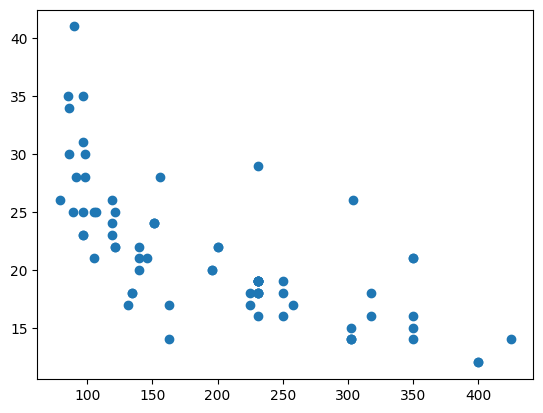

In [334]:
plt.scatter(cars.displacement, cars.mpg)

The following function will take an array of features `x`, an array of targets `y`, a fraction `p`, and split them into `train` and `test` sets.

In [335]:
def TrainTestSplit(x,y,p,seed=1):
  '''Splits datasets x and y into train and test sets
  p is the fraction going to train'''
  np.random.seed(seed) #controls randomness
  size=len(x)
  train_size=int(p*size)
  train_mask=np.zeros(size,dtype=bool)
  train_indices=np.random.choice(size, train_size, replace=False)
  train_mask[train_indices]=True
  test_mask=~train_mask
  x_train=x[train_mask]
  x_test=x[test_mask]
  y_train=y[train_mask]
  y_test=y[test_mask]
  return x_train,x_test,y_train,y_test

Let's apply this to the `displacement` and `mpg` columns of the `cars` dataset, and then view the resulting train and test sets.

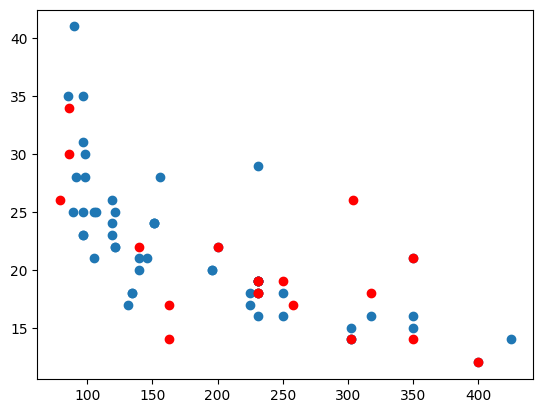

In [336]:
x_train,x_test,y_train,y_test=TrainTestSplit(cars.displacement,cars.mpg,0.75)
plt.scatter(x_train,y_train)
plt.scatter(x_test,y_test,color='r')

Eventully, we will use gradient descent to build a polynomial model of a data set of degree d. To this end, we will need a helper function to take an array `x` and create a feature matrix of shape `(len(x),d+1)`, whose `i`th column is the array `x**i`.

In [337]:
def PolyFeatures(x,d):
  X=np.zeros((len(x),d+1))
  for i in range(d+1):
    X[:,i]=x**i
  return X

Next, we'll need a functions that `scale` and `unscale` data. It's best to do this as methods associated with a class, so that scaling can be determined by one dataset but applied to another.

In [338]:
class Scaler:
  def __init__(self,z):
    self.min=np.min(z)
    self.max=np.max(z)

  def scale(self,x):
    return (x-self.min)/(self.max-self.min)

  def unscale(self,x):
    return x*(self.max-self.min)+self.min

We can now create objects of this class that will govern how scaling and unscaling work in the x and y directions:

In [339]:
xscaler=Scaler(x_train)
yscaler=Scaler(y_train)

Try these out by uncommenting and running some of the code below. Can you tell what they do?

In [340]:
xscaler.scale(x_train)
xscaler.scale(x_test)
yscaler.unscale(yscaler.scale(y_test))

1     17.0
5     18.0
6     26.0
9     19.0
11    14.0
12    21.0
16    22.0
18    19.0
20    18.0
25    12.0
28    22.0
29    14.0
37    18.0
42    34.0
50    19.0
62    30.0
63    14.0
64    26.0
73    17.0
Name: mpg, dtype: float64

Our next task is to write a function that determines the coefficients of a linear model with feature matrix `X` and target `y`. The model will be defined by an array of coefficients, one for each column in `X`.

In [341]:
def train(X,y,max_iter,lr):
  coeff=np.ones(X.shape[1])
  for i in range(max_iter):
    resid=X@coeff-y
    gradient=2*((X.T)@resid)
    coeff=coeff-lr*gradient #Here's the Gradient Descent!
  return coeff

Next, let's create a prediction function which takes a feature matrix `X` and a model determined by coefficients `coeff` and makes predictions:

In [342]:
def predict(X,coeff):
  return X@coeff

Let's put everything together and see it in action! The code below trains a degree 5 polynomial model on x_train, y_train, and uses it to make predictions on x_test. Then, we plot the resulting curve, together with the train and test datasets.

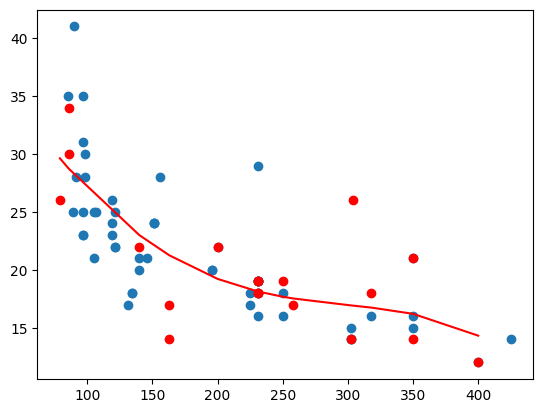

In [343]:
x_train_scaled=xscaler.scale(x_train) #scale train feature
y_train_scaled=yscaler.scale(y_train) #scale train target
X_train=PolyFeatures(x_train_scaled,5) #create deg 5 feature matrix for training
coeff=train(X_train,y_train_scaled,10000,0.01) #generate coefficients of model
x_test_scaled=xscaler.scale(x_test.sort_values()) #scale x_test (sort_values is only necessary for plotting later)
X_test=PolyFeatures(x_test_scaled,5) #create deg 5 feature matrix
pred_scaled=predict(X_test,coeff) #generate scaled predictions
pred=yscaler.unscale(pred_scaled) #unscale to create predictions
plt.scatter(x_train,y_train) #plot train data
plt.scatter(x_test,y_test,color='r') #plot test data
plt.plot(x_test.sort_values(),pred,'-r') #plot model, connect the dots

Finally, we put this all into a function to generate the MSE for the test set, for different values of max_iter, learning rate, and degree.

In [344]:
def PolyScalePredictTest(max_iter,lr,d):
  x_train_scaled=xscaler.scale(x_train) #scale train feature
  y_train_scaled=yscaler.scale(y_train) #scale train target
  X_train=PolyFeatures(x_train_scaled,d) #create deg d feature matrix for training
  coeff=train(X_train,y_train_scaled,max_iter,lr) #generate coefficients of model
  x_test_scaled=xscaler.scale(x_test) #scale test feature
  X_test=PolyFeatures(x_test_scaled,d) #create deg d feature matrix for testing
  pred_scaled=predict(X_test,coeff) #generate scaled predictions for test features
  pred=yscaler.unscale(pred_scaled) #unscale to create predictions
  MSE=np.sum((pred-y_test)**2)/len(y_test) #compute MSE
  return MSE

Now run this code to generate a list of MSE's for different degree models:

In [345]:
[PolyScalePredictTest(10000,0.01,d) for d in range(1,8)]

[18.41871274649611,
 16.128655387350417,
 13.581353377567783,
 12.991604621736052,
 13.254988115376417,
 13.357806234258186,
 13.290761780843301]

You should see that the fourth element in the list is the smallest MSE, indicating that a degree 4 polymial fits the test data best. Lower degree polynomials won't be as good, and higher degree polynomials will be overfit.

---
**Assignment**

Your assignment is to create a *linear* (not polynomial) model of the mpg column of the cars dataset, based on the displacement, weight, and gear ratio columns. That is, you will create a model of the form

$$mpg \sim a (displacement)+ b(weight) +c(gear\_ratio) +d$$

Most of the functions above can be used as-is. Be careful! Each column of your feature matrix will have to be scaled differently before running the `train()` function on it.

When you do the train/test split, use `p=0.75` and don't change the default value of seed. Train your model using `max_iter=10000` and `lr=0.01`. Finally, make predictions based on the test set, and report your MSE.

In [346]:
ROW = 0
COLUMN = 1

In [347]:
X=np.array(cars[['displacement','weight','gear_ratio']])
X = np.append(X, np.ones((X.shape[0], 1)), axis = COLUMN)
y=cars.mpg

In [348]:
X_train,X_test,y_train,y_test=TrainTestSplit(X,y,0.75)

In [349]:
X_train_scaled = xscaler.scale(X_train[:, :-1])
X_train_scaled = np.append(X_train_scaled, np.ones((X_train_scaled.shape[0], 1)), axis = COLUMN)

X_test_scaled = xscaler.scale(X_test[:, :-1])
X_test_scaled = np.append(X_test_scaled, np.ones((X_test_scaled.shape[0], 1)), axis = COLUMN)

In [350]:
y_train_scaled=yscaler.scale(y_train)

In [351]:
max_iter = 10000
lr = 0.01
coeff=train(X_train_scaled,y_train_scaled,max_iter,lr)

/var/folders/pc/1h9xlpvd7rd5xtvc_7rkfznr0000gn/T/ipykernel_18480/2695862374.py:6: RuntimeWarning: invalid value encountered in subtract
  coeff=coeff-lr*gradient #Here's the Gradient Descent!


In [352]:
pred_scaled=predict(X_test_scaled,coeff)

In [353]:
pred=yscaler.unscale(pred_scaled)

In [354]:
MSE=np.sum((pred-y_test)**2)/len(y_test)